# Data Visualization
1. Grab MODIS HDF file
2. Import channels
4. run data through ML models
5. display cloud masks & channel 0

In [1]:
from pyhdf.SD import SD, SDC
from pyhdf.HDF import HDF, HC
from pyhdf.SD import *
import os
import numpy as np

filenameMOD_full = os.path.join("../MODIS_full_imgs","MYD021KM.A2014001.0745.061.2018050225511.hdf")
filenameMOD_mask = os.path.join("../MODIS_full_imgs","MYD35_L2.A2014001.0745.061.2018050225753.hdf")
filenameMOD_CC = os.path.join("../MODIS_full_imgs","MAC021S0.A2014001.0745.002.2016260202206.hdf")

## Full MODIS Swath to Numpy Array
1. Open File using pyhdf's Scientific Dataset
2. Read Latitude, Longitude, and Bands
3. Close file

In [2]:
def calcRadiance(data):
    emissive = data[:]
    # Get dataset attributes
    attrs = data.attributes()
    
    # Apply scaling and offset for each channel
    radiance = np.empty(emissive.shape, dtype=np.float32)
    
    for i in range(emissive.shape[0]):
        channel_values = emissive[i, :, :]
        channel_radiance = ((channel_values.astype(np.float32) - attrs['radiance_offsets'][i]) /
                            attrs['radiance_scales'][i])
        # Handle special values
        channel_radiance[channel_values.astype(np.float32) == attrs['_FillValue']] = np.nan
        radiance[i, :, :] = channel_radiance

    return emissive

# Open HDF
hdf_file = SD(filenameMOD_full, SDC.READ)

# List SDS datasets
sds_datasets = hdf_file.datasets()

lat_mod_full = hdf_file.select('Latitude')[:]
lon_mod_full = hdf_file.select('Longitude')[:]

# Get dataset attributes
data = hdf_file.select('EV_1KM_Emissive')
attrs = data.attributes()
for attr_name in attrs.keys():
        if 'band_names' == attr_name:
            print("Attribute:", attr_name)
            print("Value:", attrs[attr_name])
# Get dataset attributes
data = hdf_file.select('EV_1KM_RefSB')
attrs = data.attributes()
for attr_name in attrs.keys():
        if 'band_names' == attr_name:
            print("Attribute:", attr_name)
            print("Value:", attrs[attr_name])
# Get dataset attributes
data = hdf_file.select('EV_250_Aggr1km_RefSB')
attrs = data.attributes()
for attr_name in attrs.keys():
        if 'band_names' == attr_name:
            print("Attribute:", attr_name)
            print("Value:", attrs[attr_name])
# Get dataset attributes
data = hdf_file.select('EV_500_Aggr1km_RefSB')
attrs = data.attributes()
for attr_name in attrs.keys():
        if 'band_names' == attr_name:
            print("Attribute:", attr_name)
            print("Value:", attrs[attr_name])

radiance_1km = calcRadiance(hdf_file.select('EV_1KM_Emissive'))
radiance_1km = np.concatenate((np.expand_dims(radiance_1km[0,:,:], axis=0), radiance_1km[6:,:,:]), axis=0)
refradiance_1km = calcRadiance(hdf_file.select('EV_1KM_RefSB'))[11:15,:,:]
refradiance_250 = calcRadiance(hdf_file.select('EV_250_Aggr1km_RefSB'))
refradiance_500 = calcRadiance(hdf_file.select('EV_500_Aggr1km_RefSB'))

# Close the HDF file
hdf_file.end()
print(np.shape(lat_mod_full))
print(np.shape(lon_mod_full))
print(np.shape(radiance_1km))
print(np.shape(refradiance_1km))
print(np.shape(refradiance_250))
print(np.shape(refradiance_500))

Attribute: band_names
Value: 20,21,22,23,24,25,27,28,29,30,31,32,33,34,35,36
Attribute: band_names
Value: 8,9,10,11,12,13lo,13hi,14lo,14hi,15,16,17,18,19,26
Attribute: band_names
Value: 1,2
Attribute: band_names
Value: 3,4,5,6,7
(406, 271)
(406, 271)
(11, 2030, 1354)
(4, 2030, 1354)
(2, 2030, 1354)
(5, 2030, 1354)


## MODIS hdf4 to Numpy Array
1. Open File using pyhdf's Scientific Dataset reader (SD)
2. Read Latitude, Longitude, and Cloud_Mask arrays
3. Close file

In [3]:
# Open HDF
hdf_file = SD(filenameMOD_CC, SDC.READ)

# List SDS datasets
sds_datasets = hdf_file.datasets()

# Get dataset attributes
data = hdf_file.select('EV_1KM_Emissive')
attrs = data.attributes()
for attr_name in attrs.keys():
        if 'band_names' == attr_name:
            print("Attribute:", attr_name)
            print("Value:", attrs[attr_name])
# Get dataset attributes
data = hdf_file.select('EV_1KM_RefSB')
attrs = data.attributes()
for attr_name in attrs.keys():
        if 'band_names' == attr_name:
            print("Attribute:", attr_name)
            print("Value:", attrs[attr_name])
# Get dataset attributes
data = hdf_file.select('EV_250_Aggr1km_RefSB')
attrs = data.attributes()
for attr_name in attrs.keys():
        if 'band_names' == attr_name:
            print("Attribute:", attr_name)
            print("Value:", attrs[attr_name])
# Get dataset attributes
data = hdf_file.select('EV_500_Aggr1km_RefSB')
attrs = data.attributes()
for attr_name in attrs.keys():
        if 'band_names' == attr_name:
            print("Attribute:", attr_name)
            print("Value:", attrs[attr_name])

# Close the HDF file
hdf_file.end()

Attribute: band_names
Value: 20,27,28,29,30,31,32,33,34,35,36
Attribute: band_names
Value: 17,18,19,26
Attribute: band_names
Value: 1,2
Attribute: band_names
Value: 3,4,5,6,7


In [4]:
features = np.concatenate((radiance_1km, refradiance_1km, refradiance_250, refradiance_500), axis=0)
print(np.shape(features))
print(np.shape(refradiance_250))

(22, 2030, 1354)
(2, 2030, 1354)


## Visualize MODIS

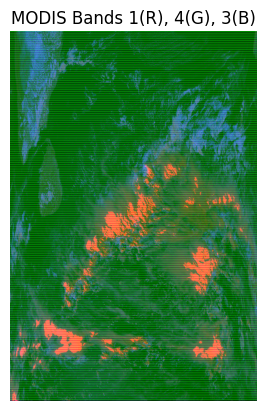

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches


r = refradiance_250[1, :, :]  # Band 1
g = refradiance_500[3, :, :]  # Band 4
b = refradiance_500[4, :, :]  # Band 3

# Normalize reflectance data
r = (r - np.min(r)) / (np.max(r) - np.min(r))
g = (g - np.min(g)) / (np.max(g) - np.min(g))
b = (b - np.min(b)) / (np.max(b) - np.min(b))

rgb = np.dstack((r,g,b))

# Display RGB image
plt.imshow(np.flipud(np.fliplr(rgb)))
plt.title('MODIS Bands 1(R), 4(G), 3(B)')
plt.axis('off')
plt.show()

## MODIS MASK to hdf 4

In [6]:
# Open HDF
hdf_file = SD(filenameMOD_mask, SDC.READ)

# List SDS datasets
sds_datasets = hdf_file.datasets()

# Iterate through SDS datasets
for dataset_name in sds_datasets:
    
    print("SD dataset name:", dataset_name)
    if 'Latitude' in dataset_name:
        latitude_data_mod = hdf_file.select(dataset_name)[:]
    elif 'Longitude' in dataset_name:
        longitude_data_mod = hdf_file.select(dataset_name)[:]
    elif 'Cloud_Mask' == dataset_name:
        data = hdf_file.select(dataset_name)
        dataarray = data[:]
        dataarray = dataarray[0,:,:]
        print(np.shape(dataarray))
        dataarray = np.ravel(dataarray)

        # Gather data as Bytes
        binary_data = [format(byte & 0xFF, '08b') for byte in dataarray]
        # Gather 2nd and 3rd bit from right
        extracted_bits = [byte[-3:-1] for byte in binary_data]
        # Cloud mask information, simplify to [1,0]
        cloud_mask_mod = [0 if bits in ['11'] else 1 for bits in extracted_bits]
        
# Close HDF
hdf_file.end()
print(np.shape(cloud_mask_mod))
cloud_mask_mod = np.reshape(cloud_mask_mod, (2030,1354))

SD dataset name: Latitude
SD dataset name: Longitude
SD dataset name: Scan_Start_Time
SD dataset name: Solar_Zenith
SD dataset name: Solar_Azimuth
SD dataset name: Sensor_Zenith
SD dataset name: Sensor_Azimuth
SD dataset name: Cloud_Mask_SPI
SD dataset name: Cloud_Mask
(2030, 1354)
SD dataset name: Quality_Assurance
(2748620,)


## Visualize Cloud Mask

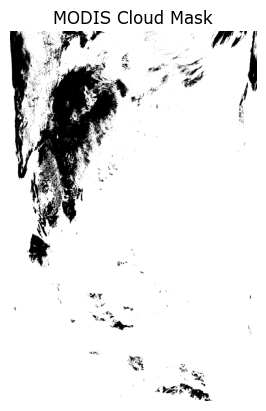

In [7]:
# CLOUD MASK
gray = np.flipud(np.fliplr(cloud_mask_mod))

# Display RGB image
plt.imshow(gray, cmap='gray')
plt.title('MODIS Cloud Mask', fontname='Verdana')
plt.axis('off')
plt.show()

## Visualize Random Forest Mask

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import joblib

rf_classifier = joblib.load("../Saved_ML_Models/rf_model.joblib")
rf_scaler = joblib.load("../Saved_ML_Models/rf_scaler.joblib")

In [9]:
features = np.reshape(features, (22,2030*1354))
features = features.T
features = rf_scaler.transform(features)
rf_mask = rf_classifier.predict(features)
rf_mask = np.reshape(rf_mask, (2030,1354))

In [10]:
print(features[0,:])

[ -0.96604263  -3.07195915  -2.91624808  -2.30011877  -2.90905303
  -2.72657618  -2.9474797   -4.32151512  -5.31559623  -6.75208454
 -10.6557546   -0.49056099  -0.54165745  -0.53843262  -0.29853806
  -0.59312064  -0.55715085  -0.67286565  -0.6238744   -0.6125314
  -1.03597593  -0.55240855]


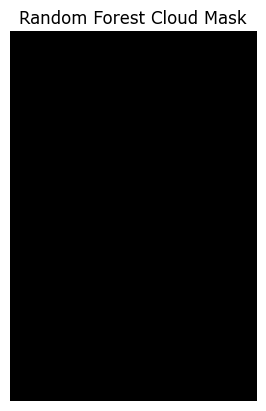

In [11]:
# CLOUD MASK
gray = np.flipud(np.fliplr(rf_mask))

# Display RGB image
plt.imshow(gray, cmap='gray')
plt.title('Random Forest Cloud Mask', fontname='Verdana')
plt.axis('off')
plt.show()